# Reproduce the table with photometric uncertainties on the Gaia science performance pages

The code below shows how to reproduce the numbers in the [table of photometric uncertainties](https://www.cosmos.esa.int/web/gaia/science-performance#photometric%20performance) on the Gaia science performance web pages. This notebook also serves as a test to verify that the numbers on the science performance pages are correctly reproduced.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pygaia.errors.photometric import magnitude_uncertainty as magunc
from pygaia.photometry.transformations import gbrminv_from_vminic

plt.style.use("./agab.mplstyle")

## Calculating the uncertainties at fixed $G$ for different spectral types

The code below uses the [transformations from the Johnson-Cousins to the Gaia photometric systems](https://gea.esac.esa.int/archive/documentation/GDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html) to assign the correct values of $G_\mathrm{BP}$ and $G_\mathrm{RP}$, given $G$, for stars of different spectral types (B1V, G2V, M6V).

__NOTE__ The values of $(V-I)_\mathrm{c}$ for the spectal types above are as used on the [Gaia science performance pages](https://www.cosmos.esa.int/web/gaia/science-performance#photometric%20performance). They are slightly different from the result of `vminic_from_spt()` from the `pygaia.photometry.utils` module.

In [2]:
gmags = np.arange(13,21)
gbpmags = {}
grpmags = {}
spt_vminic = {"B1V":-0.22, "G2V":0.75, "M6V":3.85}

for spt in spt_vminic.keys():
    gminv, bpminv, rpminv, _ = gbrminv_from_vminic(spt_vminic[spt])
    gbpmags[spt] = gmags + bpminv - gminv
    grpmags[spt] = gmags + rpminv - gminv

dfs = {}
for spt in spt_vminic.keys():
    dfs[spt] = pd.DataFrame({"G":gmags})
    for release in ["dr3", "dr4", "dr5"]:
        dfs[spt][f"sigG_{release.upper()}"] = magunc("g", gmags, release=release)
    for release in ["dr3", "dr4", "dr5"]:
        valid = gbpmags[spt] <= 21.0
        uncs = np.zeros(gmags.size)
        uncs[valid] = magunc("bp", gbpmags[spt][valid], release=release)
        uncs[np.logical_not(valid)] = np.nan
        dfs[spt][f"sigBP_{release.upper()}"] = uncs
    for release in ["dr3", "dr4", "dr5"]:
        valid = grpmags[spt] <= 21.0
        uncs = np.zeros(gmags.size)
        uncs[valid] = magunc("rp", grpmags[spt][valid], release=release)
        uncs[np.logical_not(valid)] = np.nan
        dfs[spt][f"sigRP_{release.upper()}"] = uncs

## Recreate the tables from the Gaia performance pages

In [3]:
spt="B1V"
dfs[spt].style.format("{:.1f}").hide(axis="index").set_caption(spt)

G,sigG_DR3,sigG_DR4,sigG_DR5,sigBP_DR3,sigBP_DR4,sigBP_DR5,sigRP_DR3,sigRP_DR4,sigRP_DR5
13.0,0.2,0.1,0.1,0.6,0.5,0.3,0.6,0.4,0.3
14.0,0.2,0.1,0.1,0.8,0.6,0.4,1.0,0.7,0.5
15.0,0.3,0.2,0.1,1.2,0.9,0.6,1.8,1.4,1.0
16.0,0.4,0.3,0.2,2.2,1.7,1.2,3.8,2.9,2.0
17.0,0.7,0.6,0.4,4.3,3.3,2.3,8.4,6.3,4.5
18.0,1.3,1.0,0.7,8.9,6.7,4.8,17.6,13.3,9.4
19.0,2.4,1.8,1.3,19.7,14.9,10.5,38.9,29.4,20.8
20.0,4.5,3.4,2.4,41.8,31.6,22.4,82.6,62.5,44.2


In [4]:
spt="G2V"
dfs[spt].style.format("{:.1f}").hide(axis="index").set_caption(spt)

G,sigG_DR3,sigG_DR4,sigG_DR5,sigBP_DR3,sigBP_DR4,sigBP_DR5,sigRP_DR3,sigRP_DR4,sigRP_DR5
13.0,0.2,0.1,0.1,0.6,0.5,0.3,0.4,0.3,0.2
14.0,0.2,0.1,0.1,0.9,0.7,0.5,0.6,0.5,0.3
15.0,0.3,0.2,0.1,1.5,1.2,0.8,1.1,0.9,0.6
16.0,0.4,0.3,0.2,2.9,2.2,1.6,2.2,1.7,1.2
17.0,0.7,0.6,0.4,5.8,4.4,3.1,4.7,3.5,2.5
18.0,1.3,1.0,0.7,12.4,9.4,6.6,10.2,7.7,5.4
19.0,2.4,1.8,1.3,27.2,20.5,14.5,21.3,16.1,11.4
20.0,4.5,3.4,2.4,58.4,44.1,31.2,48.8,36.9,26.1


In [5]:
spt="M6V"
dfs[spt].style.format("{:.1f}", na_rep="-").hide(axis="index").set_caption(spt)

G,sigG_DR3,sigG_DR4,sigG_DR5,sigBP_DR3,sigBP_DR4,sigBP_DR5,sigRP_DR3,sigRP_DR4,sigRP_DR5
13.0,0.2,0.1,0.1,1.6,1.2,0.9,0.4,0.3,0.2
14.0,0.2,0.1,0.1,3.1,2.3,1.7,0.4,0.3,0.2
15.0,0.3,0.2,0.1,6.2,4.7,3.3,0.7,0.5,0.4
16.0,0.4,0.3,0.2,13.4,10.1,7.2,1.2,0.9,0.6
17.0,0.7,0.6,0.4,29.1,22.0,15.6,2.3,1.8,1.2
18.0,1.3,1.0,0.7,62.9,47.5,33.6,5.0,3.8,2.7
19.0,2.4,1.8,1.3,-,-,-,10.9,8.2,5.8
20.0,4.5,3.4,2.4,-,-,-,22.8,17.2,12.2


## Show the photometric uncertainties as a function of $G$

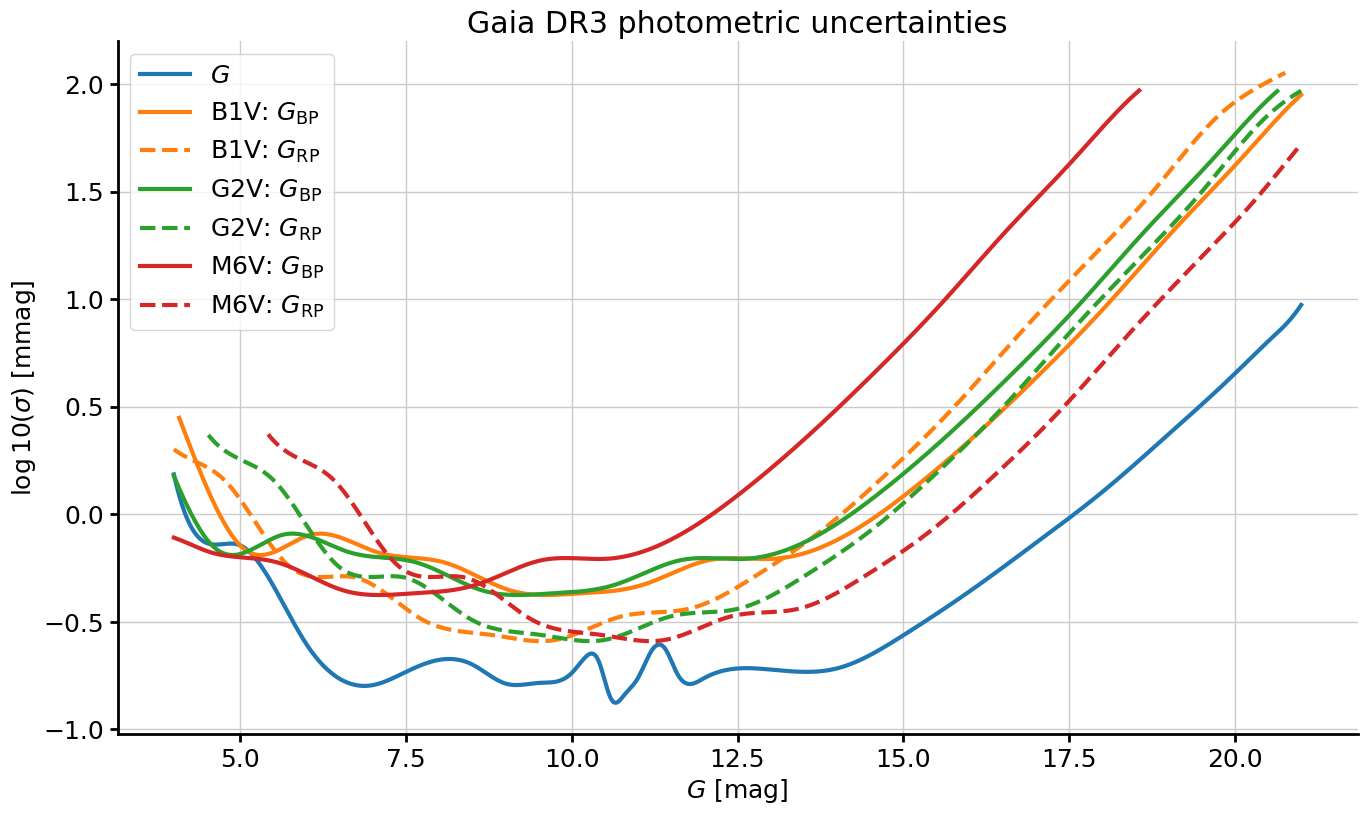

In [6]:
gmags = np.linspace(4,21,17*50)
gbpmags = {}
grpmags = {}

for spt in spt_vminic.keys():
    gminv, bpminv, rpminv, _ = gbrminv_from_vminic(spt_vminic[spt])
    gbpmags[spt] = gmags + bpminv - gminv
    grpmags[spt] = gmags + rpminv - gminv

dfs = {}
for spt in spt_vminic.keys():
    dfs[spt] = pd.DataFrame({"G":gmags})
    for release in ["dr3", "dr4", "dr5"]:
        dfs[spt][f"sigG_{release.upper()}"] = magunc("g", gmags, release=release)
    for release in ["dr3", "dr4", "dr5"]:
        valid = (gbpmags[spt] <= 21.0) & (gbpmags[spt] >= 4.0)
        uncs = np.zeros(gmags.size)
        uncs[valid] = magunc("bp", gbpmags[spt][valid], release=release)
        uncs[np.logical_not(valid)] = np.nan
        dfs[spt][f"sigBP_{release.upper()}"] = uncs
    for release in ["dr3", "dr4", "dr5"]:
        valid = (grpmags[spt] <= 21.0) & (grpmags[spt] >= 4.0)
        uncs = np.zeros(gmags.size)
        uncs[valid] = magunc("rp", grpmags[spt][valid], release=release)
        uncs[np.logical_not(valid)] = np.nan
        dfs[spt][f"sigRP_{release.upper()}"] = uncs

fig, ax = plt.subplots(1, 1, figsize=(16,9))

release = "dr3"
ax.plot(gmags, np.log10(dfs["B1V"][f"sigG_{release.upper()}"]), "-", lw=3, label=r"$G$")
for spt, kleur in zip(spt_vminic.keys(), ["C1", "C2", "C3"]):
    ax.plot(gmags, np.log10(dfs[spt][f"sigBP_{release.upper()}"]), "-", c=kleur, lw=3, label=rf"{spt}: $G_\mathrm{{BP}}$")
    ax.plot(gmags, np.log10(dfs[spt][f"sigRP_{release.upper()}"]), "--", c=kleur, lw=3, label=rf"{spt}: $G_\mathrm{{RP}}$")
ax.grid(True)
ax.set_xlabel(r"$G$ [mag]")
ax.set_ylabel(r"$\log10(\sigma)$ [mmag]")
ax.legend()
ax.set_title(f"Gaia {release.upper()} photometric uncertainties")
    
plt.show()